# Pytorch Primer for Neural Networks

Pytorch is the leading framework for building neural networks and deep learning models. Find detailed info here: https://pytorch.org

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display

FOLDER = './'
iris = pd.read_csv(FOLDER+"iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
%matplotlib inline
# settings for jupyter book: svg for html version, high-resolution png for pdf
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'png')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

Pytorch works with tensors. Think about them as multidimensional matrices. We can easily convert numpy arrays in tensors. Then we shal split training and test as required.

In [6]:
X = torch.tensor(iris.drop("class", axis=1).values, dtype=torch.float)
y = torch.tensor(
    [0 if vty == "Iris-setosa" else 1 if vty == "Iris-versicolor" else 2 for vty in iris["class"]], 
    dtype=torch.long
)
num_feats = X.shape[1]
num_class = len(torch.unique(y))

print(X.shape, y.shape)

torch.Size([150, 4]) torch.Size([150])


Let's now split the data and use the dataloader of pytorch to automatically build generators of batches of data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, random_state=42, stratify=y_train)
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
val_loader = DataLoader(val_data, batch_size=len(val_data.tensors[0]))

print("Training data batches:")
for X, y in train_loader:
    print(X.shape, y.shape)

    
print("\nTest data batches:")
for X, y in test_loader:
    print(X.shape, y.shape)

print("\nValidation data batches:")
for X, y in val_loader:
    print(X.shape, y.shape)

Training data batches:
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([11, 4]) torch.Size([11])

Test data batches:
torch.Size([23, 4]) torch.Size([23])

Validation data batches:
torch.Size([20, 4]) torch.Size([20])


### Building a model

Almost everything in a PyTorch neural network comes from torch.nn,

- ***nn.Module*** contains the larger building blocks (layers)
- ***nn.Parameter*** contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
- ***forward()*** tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
- ***torch.optim*** contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

Now we are going to build a simple Dense model. Here's what we need to do:

1) Constructing a model by subclassing nn.Module.
2) Defining a loss function and optimizer.
3) Creating a training loop.



Given what we said before, to build our mode, we want to subclass the nn.Module (almost all PyTorch models are subclasses of nn.Module).

We will create 3 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y plus an *"hidden"* layer.

We will define a forward() method containing the forward pass computation of the model.

Finally we will instantiate the model class.

In [8]:
class IrisNet(nn.Module):
    def __init__(self, n_in: int, n_out: int):
        super().__init__()
        self.input = nn.Linear(in_features=n_in, out_features=16)
        self.hidden_1 = nn.Linear(in_features=16, out_features=25)
        self.output = nn.Linear(in_features=25, out_features=n_out)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_1(x))
        return self.output(x)
    
    
model = IrisNet(num_feats, num_class)
print(model)

IrisNet(
  (input): Linear(in_features=4, out_features=16, bias=True)
  (hidden_1): Linear(in_features=16, out_features=25, bias=True)
  (output): Linear(in_features=25, out_features=3, bias=True)
)


In [9]:
class IrisNetSeq(nn.Module):
    def __init__(self, n_in: int, n_out: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=n_in, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=n_out),
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

model_seq = IrisNetSeq(num_feats, num_class)
print(model_seq)

IrisNetSeq(
  (layer_stack): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)


The number of hidden units you can use in neural network layers is a hyperparameter (a value you can set yourself) and there's no set in stone value you have to use.

Generally more is better but there's also such a thing as too much. The amount you choose will depend on your model type and dataset you're working with.

Since our dataset is small and simple, we'll keep it small and simple.

Of course input and output dimension should be consistent across layers

#### Loss Setup
For a regression problem (predicting a number) you might use mean absolute error (MAE).

For classification problems you'll often use [binary] cross entropy.

There are however a **MULTITUDE** of different losses already implemented, and bear in mind that creating  custom losses is at the core of many machine learning papers

We will also select an optimizer. Usually you'll go with classic SGD or Adam.

In [10]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

Let's also prepare a quick function to compute accuracy

In [11]:
def accuracy_fn(pred_y, y):
    return torch.mean((pred_y == y).float()).item()

#### Model Training

1) **Forward pass** - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).
2) **Calculate the loss** - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).
3) **Zero gradients** - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).
4) **Perform backpropagation on the loss** - Compute the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).
5) **Step the optimizer (gradient descent)** - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

In [12]:
num_epochs = 100
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Train set
    model.train()
    for X, y in train_loader:
        # 1. Forward pass
        preds = model.forward(X)
        pred_labels = torch.argmax(preds, axis=1)
        # 2. Calculate loss/accuracy
        loss = loss_function(preds, y)
        train_losses.append(loss)
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backwards
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
    train_accuracies.append(
        accuracy_fn(pred_labels,y)
    )
    
    # Testing
    model.eval()
    with torch.inference_mode():
        X, y = next(iter(val_loader))
        preds = model.forward(X)
        pred_labels = torch.argmax(preds, axis=1)
        val_loss = loss_function(preds, y)
        val_losses.append(val_loss)
        val_accuracies.append(
            accuracy_fn(pred_labels,y)
        )
        if (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 20/100, Train Loss: 0.0102, Validation Loss: 0.0567
Epoch 40/100, Train Loss: 0.0244, Validation Loss: 0.0567
Epoch 60/100, Train Loss: 0.0888, Validation Loss: 0.0357
Epoch 80/100, Train Loss: 0.2287, Validation Loss: 0.0270
Epoch 100/100, Train Loss: 0.0039, Validation Loss: 0.0387


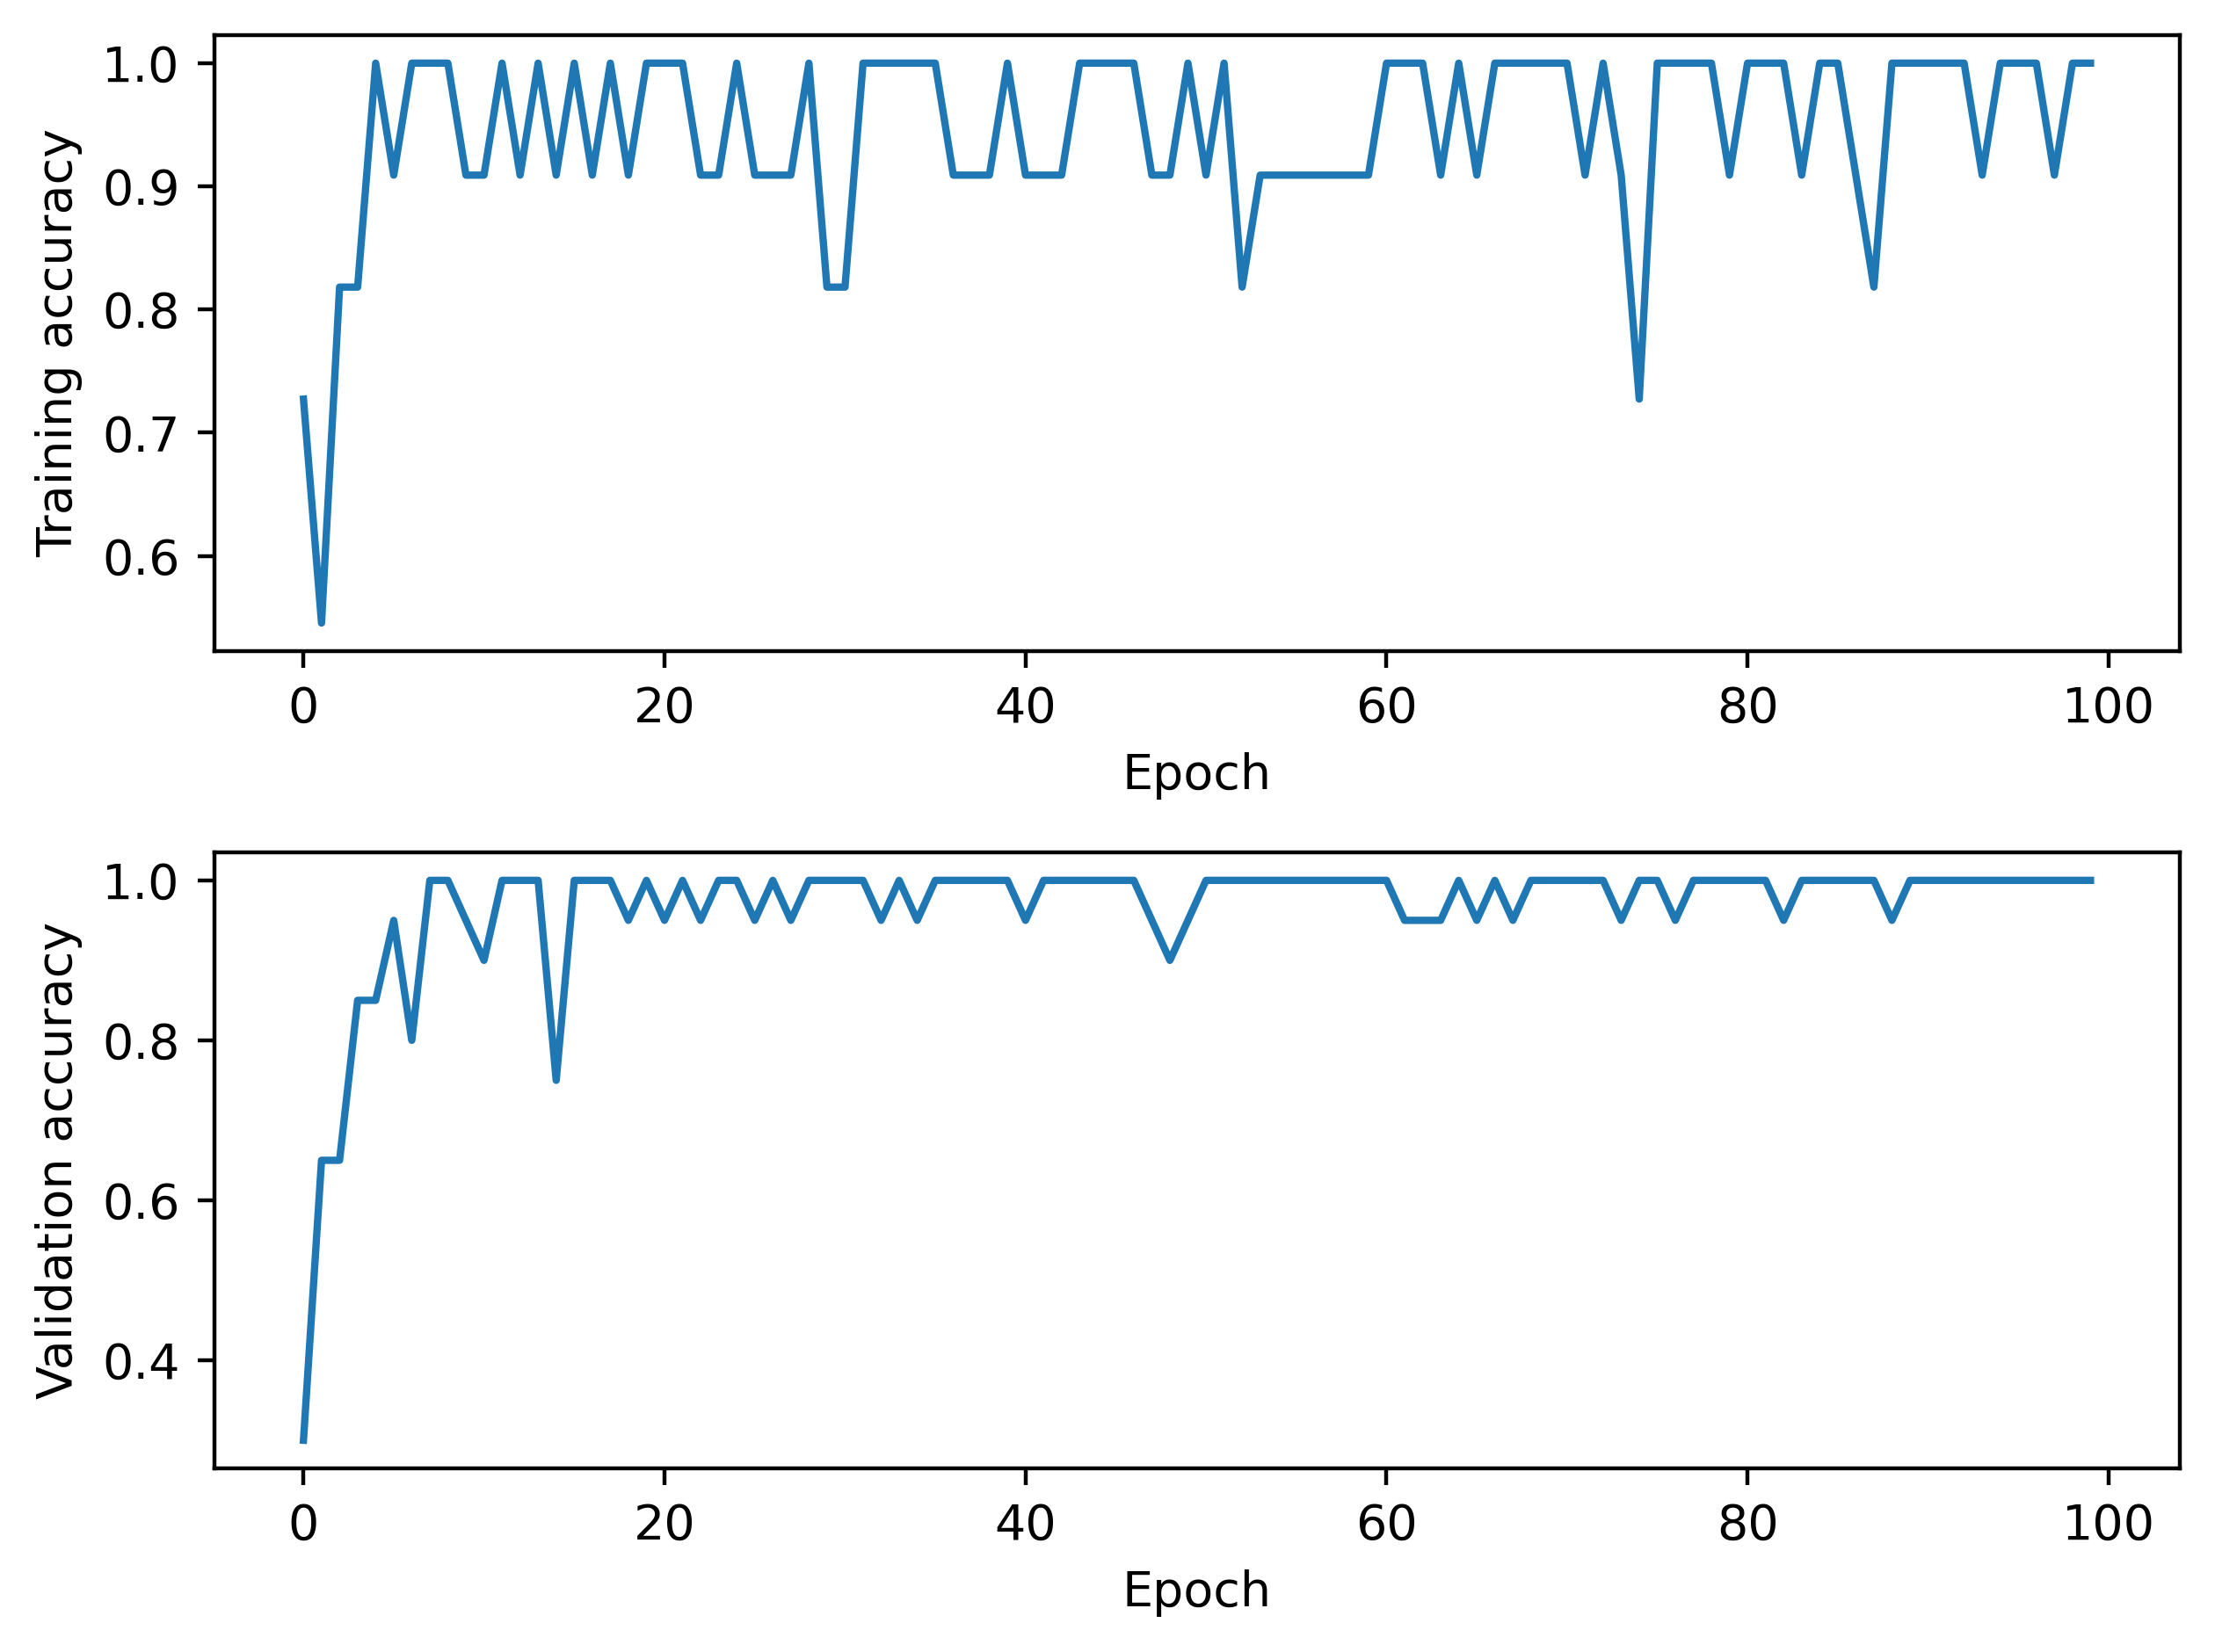

In [13]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy")

ax = fig.add_subplot(gs[1, 0])
ax.plot(val_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation accuracy")

fig.align_labels()
plt.show()

In [14]:
model.eval()

with torch.inference_mode():
    test_preds = model(X_test) 
    test_labels = torch.argmax(test_preds, axis=1)

In [15]:
from sklearn.metrics import classification_report

In [16]:
print(classification_report(test_labels,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



In [17]:
test_preds

tensor([[  0.0290,   3.6030,  -6.1756],
        [-14.5330,   1.7590,   4.3114],
        [-10.6457,   2.7520,   1.0467],
        [ -2.4085,   3.5853,  -4.7671],
        [ 15.5963,   7.1783, -21.0022],
        [ -4.9306,   3.5659,  -3.4109],
        [ 13.7645,   6.3672, -18.5915],
        [ 14.0234,   6.4749, -18.9379],
        [-18.5844,   1.2659,   6.8108],
        [ -4.0408,   3.3272,  -3.4918],
        [  0.2324,   3.5609,  -6.2448],
        [-18.5193,   1.7180,   6.2654],
        [-14.8779,   1.8150,   4.3472],
        [-18.7950,   1.2868,   6.8869],
        [ 17.8928,   8.1925, -24.0372],
        [ 15.0249,   6.9182, -20.2511],
        [ -8.3653,   2.3460,   0.4142],
        [-15.3391,   1.8466,   4.4608],
        [ -7.0741,   3.1240,  -1.5578],
        [ 16.1484,   7.4075, -21.7362],
        [-14.6672,   1.7948,   4.2406],
        [ 15.3904,   7.0828, -20.7242],
        [-11.6700,   2.0499,   2.4776]])